In [2]:
%load_ext autoreload
%autoreload 2
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import sys
sys.path.insert(0, "../scripts")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
input_shape = (224, 224, 3)

In [3]:
encoder = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_shape=input_shape)

In [4]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
import numpy as np

In [6]:
x=np.array(encoder.layers[1].get_weights()[0])

In [33]:
encoder.get_layer("flatten")

### Drop last two layers

In [92]:
encoder.layers.pop()
encoder.layers.pop()

In [70]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [71]:
last_dense = encoder.layers.pop()

In [72]:
last_flatten = encoder.layers.pop()

In [6]:
def expand_dimension(old_weights):
    '''
        Function to expand the weights from (3, 3, 3, 64) to (3, 3, 4, 64) to accomodate the extra channel for the trimap
        The extra values are initialized with random numbers
    '''
    W, b = old_weights
    W_np = np.array(W)
    #initialize with random values (original paper uses zeros is this a problem???)
    W_new = np.random.rand(3, 3, 4, 64)
    #positions that are present in original values are preserved
    W_new[:, :, 0:3, :] = W_np
    return W_new, b

In [7]:
def copy_conv(layer, inp, weights):
    filters = layer.filters
    kernel_size = layer.kernel_size
    strides = layer.strides
    padding = layer.padding
    data_format = layer.data_format
    dilation_rate = layer.dilation_rate
    activation = layer.activation
    use_bias = layer.use_bias
    kernel_initializer = layer.kernel_initializer
    bias_initializer = layer.bias_initializer
    kernel_regularizer = layer.kernel_regularizer
    bias_regularizer = layer.bias_regularizer
    activity_regularizer = layer.activity_regularizer
    kernel_constraint = layer.kernel_constraint
    bias_constraint = layer.bias_constraint
    name = layer.name
    return Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, 
                  data_format=data_format, dilation_rate=dilation_rate, activation=activation, 
                  use_bias=use_bias, kernel_initializer=kernel_initializer, 
                  bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer, 
                  bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer, 
                  kernel_constraint=kernel_constraint, bias_constraint=bias_constraint, name=name, weights=weights)(inp)

In [8]:
def copy_max_pool(layer, inp, weights):
    pool_size = layer.pool_size
    strides = layer.strides
    padding = layer.padding
    data_format = layer.data_format
    name = layer.name
    return MaxPooling2D(pool_size=pool_size, strides=strides, 
                        padding=padding, data_format=data_format, weights=weights, name=name)(inp)

In [9]:
def convert_dense_to_conv(layer, f_dim, inp):
    '''
        Convert the dense layer to a convolutional layer.
        layer is the dense layer
        f_dim is the input dimension of the flatten layer before the dense layer - (7, 7, 512) in the original
        inp is the last convolutional layer in the original network
    '''
    input_shape = layer.input_shape
    output_dim =  layer.get_weights()[1].shape[0]
    W,b = layer.get_weights()

    shape = (f_dim[1],f_dim[2],f_dim[3],output_dim) # shape = (7, 7, 512, 4096)
    new_W = W.reshape(shape)
    return Conv2D(output_dim,
              (f_dim[1],f_dim[2]),
              strides=(1,1),
              activation=layer.activation,
              padding='valid',
              weights=[new_W,b])(inp)

In [10]:
def transform_encoder(encoder):
    '''
        This function makes the following changes to the VGG16 network:
            1) Drops the final two dense layers
            2) Changes the input dimensions from (224, 224, 3) to (320, 320, 4)
            3) Changes the filter of the first conv layer to be of size (3, 3, 4), instead of (3, 3, 3) to accomodate for the extra channel (the trimap)
            4) Converts the first dense layer to a convolutional layer
    '''
    # drop the last two dense layers
    encoder.layers.pop()
    encoder.layers.pop()
    
    # make the input images be of size 320x320 and have 4 channels (last channel will be for the trimap)
    inputs = Input(shape=(320, 320, 4))
    
    x = inputs
    for layer in encoder.layers[1:]:
        weights = layer.get_weights()
        if "Conv2D" in str(layer):
            if "block1_conv1" == layer.name:
                # Changes the weights from shape (3, 3, 3) to (3, 3, 4) to accomodate trimap in the input layer
                weights = expand_dimension(weights)
            x = copy_conv(layer, x, weights)
        elif "MaxPooling2D" in str(layer):
            x = copy_max_pool(layer, x, weights)
        elif "Flatten" in str(layer):
            # record flatten's input shape
            f_dim = layer.input_shape
        elif "Dense" in str(layer):
            # convert the dense layer to a conv layer
            x = convert_dense_to_conv(layer, f_dim, x)
    
    return Model(inputs=inputs, outputs=x)

In [116]:
encoder.get_layer("flatten").input_shape

(None, 7, 7, 512)

In [118]:
encoder.get_layer("fc1").get_weights()[1].shape

(4096,)

In [11]:
enc = transform_encoder(encoder)

ResourceExhaustedError: OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@conv2d_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/kernel, conv2d_1/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_1/kernel/Assign', defined at:
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a2d314225499>", line 1, in <module>
    enc = transform_encoder(encoder)
  File "<ipython-input-10-1925218c0afc>", line 31, in transform_encoder
    x = convert_dense_to_conv(layer, f_dim, x)
  File "<ipython-input-9-21524cf3abbd>", line 19, in convert_dense_to_conv
    weights=[new_W,b])(inp)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer.py", line 432, in __call__
    self.build(input_shapes[0])
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\layers\convolutional.py", line 138, in build
    constraint=self.kernel_constraint)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 399, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 229, in __init__
    constraint=constraint)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\variables.py", line 366, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 62, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "C:\Users\thalv\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[7,7,512,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@conv2d_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/kernel, conv2d_1/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [140]:
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 320, 320, 4)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      2368      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0         
__________

In [145]:
np.array_equal(encoder.get_layer("block1_conv2").get_weights()[0] , enc.get_layer("block1_conv2").get_weights()[0])

True

In [76]:
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)


'block1_conv2'

In [ ]:
MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

In [73]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [74]:
encoder_new = copy_expand(encoder)

In [7]:
input_layer = encoder.get_layer("block1_conv1")
weights = input_layer.get_weights()
W, b = weights
W_np = np.array(W)
W_shape = W_np.shape

In [49]:
input_layer.dilation_rate

(1, 1)

In [38]:
new_W = np.random.rand(3,3,4,64)

In [39]:
new_W[:,:,0:3, :] = W_np

In [41]:
new_W[0,0,0,1]==W_np[0,0,0,1]

True

In [50]:
model = Sequential()

In [51]:
inp = Input(shape=(320, 320, 4))
conv = Conv2D(filters=64, kernel_size=(3,3))


In [54]:
# model.add(inp)
model.add(encoder.get_layer("block1_conv1"))

In [55]:
model.summary()

ValueError: This model has never been called, this its weights have not yet been created, so no summary can be displayed. Build the model first (e.g. by calling it on some test data).

In [26]:
model = Model(inputs=inp, outputs=conv)

In [42]:
model.get_layer("conv2d_1").set_weights([new_W, b])

In [32]:
np.array(model.get_layer("conv2d_1").get_weights()[0]).shape

(3, 3, 4, 64)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def generate_trimap(alpha):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 10))

    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)

In [3]:
p_img = "D:\\Image Matting Dataset\\merged_ds_two\\1-1252426161dfXY_0.jpg"
p_alpha = "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Training_set\\all_alphas\\1-1252426161dfXY.jpg"

In [4]:
from PIL import Image

In [3]:
import sys

In [4]:
sys.path.append("../scripts")

In [7]:
from losses import *

In [8]:
from crop import *

In [8]:
img = Image.open(p_img).convert('RGB')
alpha = Image.open(p_alpha).convert("RGB")

In [9]:
trimap = generate_trimap(np.array(alpha))

In [16]:
trimap[:, :, 0].shape

(615, 410)

In [9]:
from matplotlib.pyplot import imshow


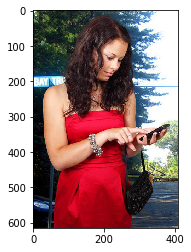

In [80]:
imshow(img)

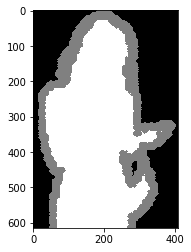

In [231]:
imshow(trimap)

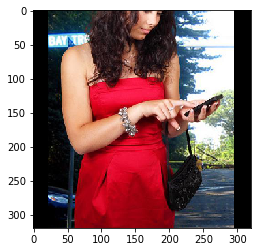

In [272]:
crop = crop_trimap_centered(np.array(img), trimap[:, :, 0], (480, 480))
imshow(crop)

In [26]:
np.array(img).dtype

dtype('uint8')

In [5]:
from data_generator import DataGenerator

Using TensorFlow backend.


In [10]:
gen = DataGenerator("D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\test_ds\\", "D:\\Image Matting Dataset\\adobe dataset\\Combined_Dataset\\Test_set\\alpha\\", 4, True)

In [15]:
x=gen[0]

In [344]:
x[0][1].shape

(320, 320, 4)

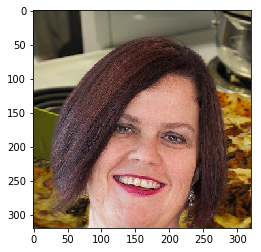

In [382]:
imshow(x[0][1][:,:,0:3])

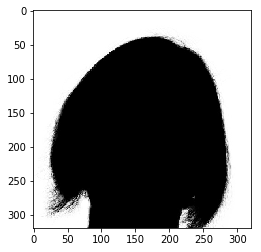

In [383]:
imshow(x[1][1].reshape((320, 320)), cmap='Greys')

In [389]:
np.unique(np.ndarray.flatten(x[0][1][:,:,3]))

array([0.       , 0.5019608, 1.       ], dtype=float32)

In [10]:
from losses import overall_loss_wrapper

In [11]:
input_tensor = Input(shape=(320, 320, 4))
out = Conv2D(1, strides=(1,1), padding="same", kernel_size=(1, 1))(input_tensor)

model = Model(input_tensor, out)
model.compile(loss=overall_loss_wrapper(input_tensor), optimizer='adam')

In [12]:
from CONSTANTS import TRIMAP_UNKNOWN_VALUE

In [13]:
TRIMAP_UNKNOWN_VALUE

0.5019607843137255

In [ ]:
X = np.random.rand(1, 320, 320, 4)
y = np.random.rand(1, 320, 320, 1)
model.test_on_batch(X, y)  # => 1.1974642

# X *= 1000
# model.test_on_batch(X, y)  # => 511.15466

##########################

In [6]:
from losses import alpha_loss_wrapper
import numpy as np

In [33]:
input_tensor = np.ones((1, 320, 320, 4)).astype(np.float32)

In [37]:
input_tensor[:, :, :, 3] = 0
input_tensor[0, 0, 0, 3] = 128/255
input_tensor[0, 1, 0, 3] = 128/255

In [20]:
input_tensor[:, :, :, 3]

array([[[0.5019608, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.5019608, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]]], dtype=float32)

In [32]:
import tensorflow as tf

In [38]:
alpha_loss = alpha_loss_wrapper(input_tensor)

In [25]:
ones = np.ones((1, 320, 320, 1)).astype(np.float32)
zeros = np.zeros((1, 320, 320, 1)).astype(np.float32)

In [39]:
x, diff, mask = alpha_loss(ones, zeros)

In [40]:
tf.Session().run(x)

1.0509971

In [44]:
EPS = 0.000001
EPS_SQ = EPS ** 2

In [42]:
z=tf.Session().run(diff)

In [48]:
np.sum(np.sqrt(np.square(z) + EPS_SQ)) / (2 + EPS)

1.051198195332909

In [49]:
m=tf.Session().run(mask)

In [53]:
z

array([[[[-1.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-1.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        ...,

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]],

        [[-0.],
         [-0.],
         [-0.],
         ...,
         [-0.],
         [-0.],
         [-0.]]]], dtype=float32)